# Analyze and visualize last.fm listening history

A slim version of the code from this article ["Analyzing Last.fm Listening History"](http://geoffboeing.com/2016/05/analyzing-lastfm-history/). The goal of this version is to provide only analysis of basic listening trends without the other information such as artist location. 

The csv data files were created with [lastfm_downloader.ipynb](lastfm_downloader.ipynb)

In [4]:
import pandas as pd
import numpy as np
import string, re, pytz
import matplotlib.pyplot as plt, matplotlib.font_manager as fm
from datetime import datetime as dt

In [5]:
def get_colors(cmap, n, start=0., stop=1., alpha=1., reverse=False):
    '''return n-length list of rgba colors from the passed colormap name and alpha,
       limit extent by start/stop values and reverse list order if flag is true'''
    import matplotlib.cm as cm, numpy as np
    colors = [cm.get_cmap(cmap)(x) for x in np.linspace(start, stop, n)]
    colors = [(r, g, b, alpha) for r, g, b, _ in colors]
    return list(reversed(colors)) if reverse else colors

## All scrobbles

In [7]:
# read the all-time scrobbles data set
scrobbles = pd.read_csv('data/lastfm_scrobbles.csv', encoding='utf-8')
scrobbles = scrobbles.drop('timestamp', axis=1)
print('{:,} total scrobbles'.format(len(scrobbles)))
print('{:,} total artists'.format(len(scrobbles['artist'].unique())))

18,643 total scrobbles
1,021 total artists


In [8]:
# convert to datetime
scrobbles['timestamp'] = pd.to_datetime(scrobbles['datetime'])

In [9]:
# functions to convert UTC to Central time zone and extract date/time elements
convert_tz = lambda x: x.to_pydatetime().replace(tzinfo=pytz.utc).astimezone(pytz.timezone('US/Central'))
get_year = lambda x: convert_tz(x).year
get_month = lambda x: '{}-{:02}'.format(convert_tz(x).year, convert_tz(x).month) 
get_day = lambda x: convert_tz(x).day
get_hour = lambda x: convert_tz(x).hour
get_day_of_week = lambda x: convert_tz(x).weekday()

In [10]:
# parse out date and time elements as central time
scrobbles['year'] = scrobbles['timestamp'].map(get_year)
scrobbles['month'] = scrobbles['timestamp'].map(get_month)
scrobbles['day'] = scrobbles['timestamp'].map(get_day)
scrobbles['hour'] = scrobbles['timestamp'].map(get_hour)
scrobbles['dow'] = scrobbles['timestamp'].map(get_day_of_week)
scrobbles = scrobbles.drop(labels=['datetime'], axis=1)

# drop rows with 01-01-1970 as timestamp
scrobbles = scrobbles[scrobbles['year'] > 1970]
scrobbles.head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,day,hour,dow
0,Against All Logic,NaN,2012 - 2017,NaN,You Are Going to Love Me and Scream,NaN,2018-07-15 19:40:19,2018,2018-07,15,14,6
1,Against All Logic,NaN,2012 - 2017,NaN,Flash In The Pan,NaN,2018-07-15 19:32:51,2018,2018-07,15,14,6
2,Against All Logic,NaN,2012 - 2017,NaN,Now U Got Me Hooked,NaN,2018-07-15 19:27:00,2018,2018-07,15,14,6
3,Against All Logic,NaN,2012 - 2017,NaN,Cityfade,NaN,2018-07-15 19:21:25,2018,2018-07,15,14,6
4,Against All Logic,NaN,2012 - 2017,NaN,Such a Bad Way,NaN,2018-07-15 19:16:26,2018,2018-07,15,14,6


## Yearly analysis

Visualize the number of scrobbles per year. In this section and all others I removed the font styling and lines that saved the charts as images.

In [11]:
year_counts = scrobbles['year'].value_counts().sort_index()

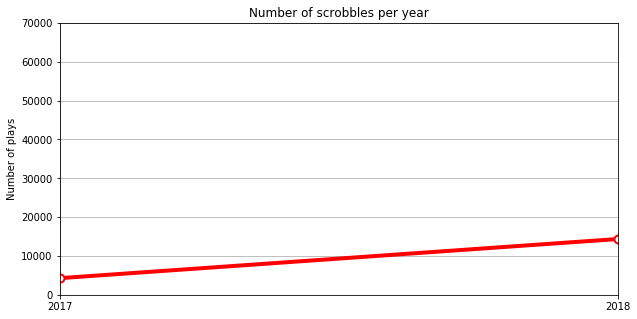

In [12]:
year_counts = scrobbles['year'].value_counts().sort_index()
ax = year_counts.plot(kind='line', figsize=[10, 5], linewidth=4, alpha=1, marker='o', color='#ff0000', 
                      markeredgecolor='#ff0000', markerfacecolor='w', markersize=8, markeredgewidth=2)

ax.set_xlim((year_counts.index[0], year_counts.index[-1]))

ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.set_ylim(0, 70000)
ax.set_xticks(year_counts.index)
ax.set_ylabel('Number of plays')

ax.set_title('Number of scrobbles per year')

plt.show()

## Monthly analysis

Visualize the number of scrobbles per month from 2010 through the present day. I also removed the lines that saved the chart as well as font stylings.

In [17]:
# get all the scrobbles from 2010-present
min_year = 2010
scrobbles_10 = scrobbles[scrobbles['year'] >= min_year]
max_year = max(scrobbles_10['year'])

In [18]:
# count number of scrobbles in each month
month_counts = scrobbles_10['month'].value_counts().sort_index()

# not every month necessarily has a scrobble, so fill in missing months with zero counts
date_range = pd.date_range(start=min(scrobbles_10['timestamp']), end=max(scrobbles_10['timestamp']), freq='D')
months_range = date_range.map(lambda x: str(x.date())[:-3])
index = np.unique(months_range)
month_counts = month_counts.reindex(index, fill_value=0)

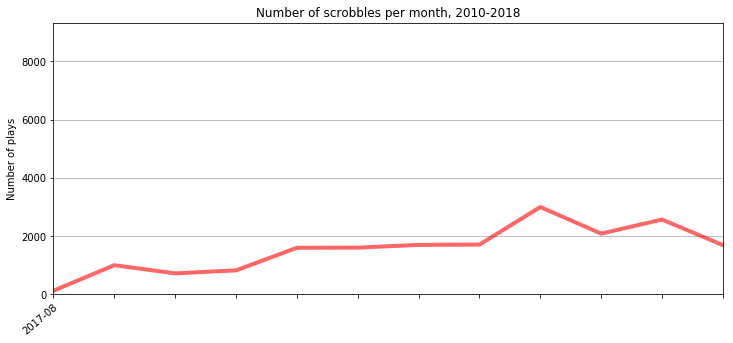

In [19]:
ax = month_counts.plot(kind='line', figsize=[12, 5], linewidth=4, alpha=0.6, color='#ff0000')

xlabels = month_counts.iloc[range(0, len(month_counts), 12)].index
xlabels = [x if x in xlabels else '' for x in month_counts.index]
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=40, rotation_mode='anchor', ha='right')

ax.set_xlim((0, len(month_counts)-1))

ax.yaxis.grid(True)
ax.set_ylim((0,(len(scrobbles)/2)))
ax.set_ylabel('Number of plays')
ax.set_title('Number of scrobbles per month, {}-{}'.format(min_year, max_year))

plt.show()

Note that I haven't been scrobbling enough to have multiple years...

## Day of the week analysis

How many songs have been played on each day of the week?

In [20]:
# get the play count sum by day of the week
dow_counts = scrobbles['dow'].value_counts().sort_index()
dow_counts.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

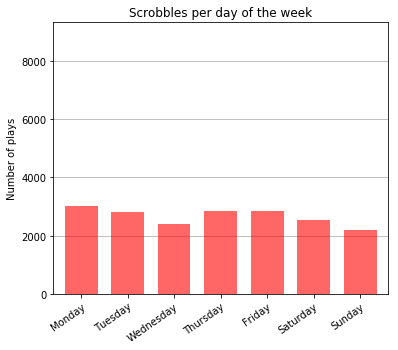

In [22]:
ax = dow_counts.plot(kind='bar', figsize=[6, 5], width=0.7, alpha=0.6, color='#ff0000', edgecolor=None, zorder=2)

ax.yaxis.grid(True)
ax.set_xticklabels(dow_counts.index, rotation=35, rotation_mode='anchor', ha='right')


ax.set_ylim((0, (len(scrobbles)/2)))
ax.set_title('Scrobbles per day of the week')
ax.set_ylabel('Number of plays')
plt.show()

## Hour of the day analysis

How many songs have been played during each hour of the day?

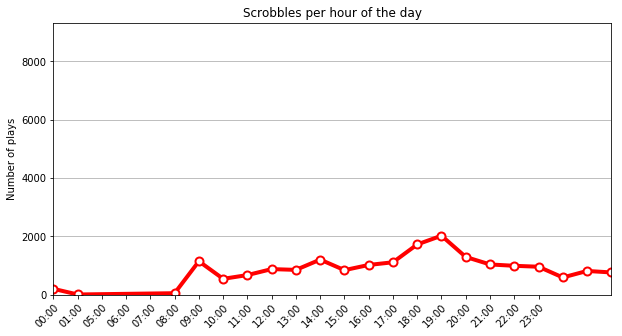

In [23]:
hour_counts = scrobbles['hour'].value_counts().sort_index()
ax = hour_counts.plot(kind='line', figsize=[10, 5], linewidth=4, alpha=1, marker='o', color='#ff0000', 
                      markeredgecolor='#ff0000', markerfacecolor='w', markersize=8, markeredgewidth=2)

xlabels = hour_counts.index.map(lambda x: '{:02}:00'.format(x))
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=45, rotation_mode='anchor', ha='right')

ax.set_xlim((hour_counts.index[0], hour_counts.index[-1]))

ax.yaxis.grid(True)
ax.set_ylim((0, (len(scrobbles)/2)))
ax.set_ylabel('Number of plays')
ax.set_title('Scrobbles per hour of the day')

plt.show()

## Analysis by day of the week + hour of the day

How many songs have been played during each hour of the day on each day of the week?

In [24]:
# get the play counts by hour of day and day of week
weekday_hour_counts = scrobbles.groupby(['dow','hour']).count()['track']
hour_numbers = weekday_hour_counts.index.levels[1]
day_numbers = weekday_hour_counts.index.levels[0]
day_names = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

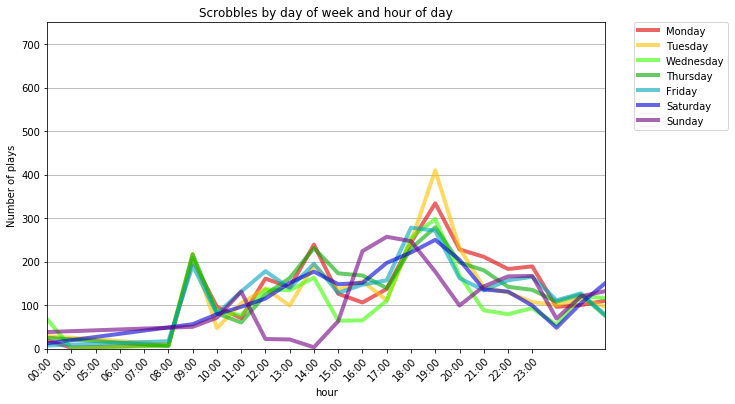

In [31]:
# get one color per day of week
colors = get_colors('nipy_spectral_r', n=len(day_numbers), start=0.1, stop=0.95)

fig, ax = plt.subplots(figsize=[10, 6])
lines = []
for day, c in zip(day_numbers, colors):
    ax = weekday_hour_counts[day].plot(kind='line', linewidth=4, alpha=0.6, c=c)
    lines.append(day_names[day])
    
xlabels = hour_numbers.map(lambda x: '{:02}:00'.format(x))
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=45, rotation_mode='anchor', ha='right')

ax.set_xlim((hour_numbers[0], hour_numbers[-1]))

ax.yaxis.grid(True)
ax.set_ylim([0, 750])
ax.set_ylabel('Number of plays')
ax.set_title('Scrobbles by day of week and hour of day')
ax.legend(lines, loc='upper right', bbox_to_anchor=(1.23,1.017))

plt.show()